# **Diagnosis prediction based on symptoms**

*The aim of the project is to use the symptom2disease dataset to build a simple text classification model that allows for disease prediction based on symptom descriptions.*

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('stopwords')
import re
from PIL import Image, ImageDraw
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings, gc

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


### Text preprocessing

In [2]:
def clean_html(text):
  html = re.compile('<.*?>')#regex
  return html.sub(r'',text)
def email_address(text):
  email = re.compile(r'[\w\.-]+@[\w\.-]+')
  return email.sub(r'',text)
def remove_(tweet):
  tweet = re.sub('([_]+)', "", tweet)
  return tweet
def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    #when the ^ is on the inside of []; we are matching any character that is not included in this expression within the []
    return re.sub(pattern, '', text)
def remove_links(tweet):
  '''Takes a string and removes web links from it'''
  tweet = re.sub(r'http\S+', '', tweet) # remove http links
  tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
  tweet = tweet.strip('[link]') # remove [links]
  return tweet
def clean_html(text):
  html = re.compile('<.*?>')#regex
  return html.sub(r'',text)
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)
def removeStopWords(str):
#select english stopwords
  cachedStopWords = set(stopwords.words("english"))
#add custom words
  cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
#remove stop words
  new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
  return new_str
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)
def punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text 
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)
def lower(text):
  return text.lower()

### Loading the Dataset

In [3]:
df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv') 
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df.sample(frac=0.5).reset_index(drop=True)
df.head()

,label,text
0,Cervical spondylosis,"Back pain, a persistent cough, and numbness in..."
1,Varicose Veins,I have noticed that the blood vessels in my le...
2,diabetes,I frequently feel the want to urinate and freq...
3,Cervical spondylosis,"My arms and legs have been weak, and I have be..."
4,gastroesophageal reflux disease,My throat feels as though food or acid is back...


In [4]:
df.shape

(600, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   600 non-null    object
 1   text    600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [6]:
df.duplicated().sum()

14

### Removing duplicates

In [7]:
df = df.drop_duplicates()
df.shape

(586, 2)

### Wordcloud from symptom descriptions

In [8]:
size = (500, 500)
mask = Image.new('RGB', size, (255, 255, 255))
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size[0], size[1]), fill=(0, 0, 0))
mask.save("circle_mask.png")

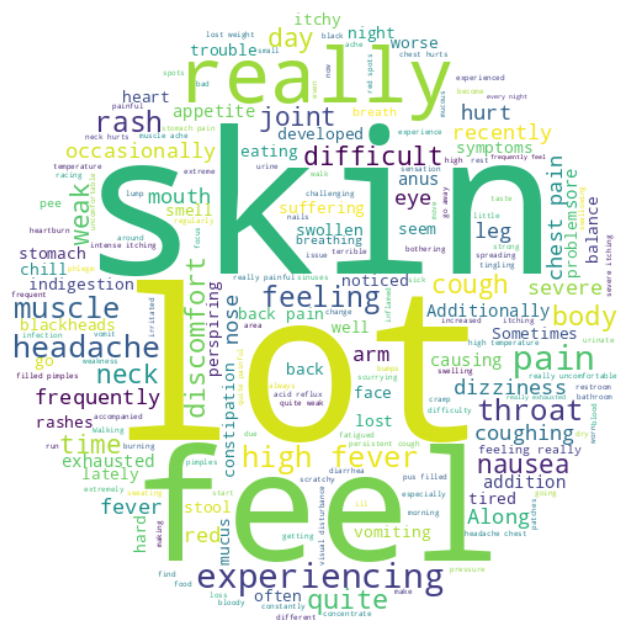

In [9]:
label_counts = df.groupby('label').size().reset_index(name='count')
sorted_labels = label_counts.sort_values(by='count', ascending=False)
sorted_df = df.merge(sorted_labels, on='label')
text = ' '.join(sorted_df['text'])
mask = np.array(Image.open("circle_mask.png"))
wc = WordCloud(background_color='white', contour_color='white', contour_width=1, mask=mask)
wordcloud = wc.generate(text)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

*After loading the dataset and removing duplicates, a Wordcloud was generated for the data. It is a visual representation of the words that appear most frequently in the dataset. To create this word cloud, I used a text column with descriptions of diseases, and as you can see, the most frequently used word in the database is the word "skin", which may mean that many descriptions contain references to skin problems.*

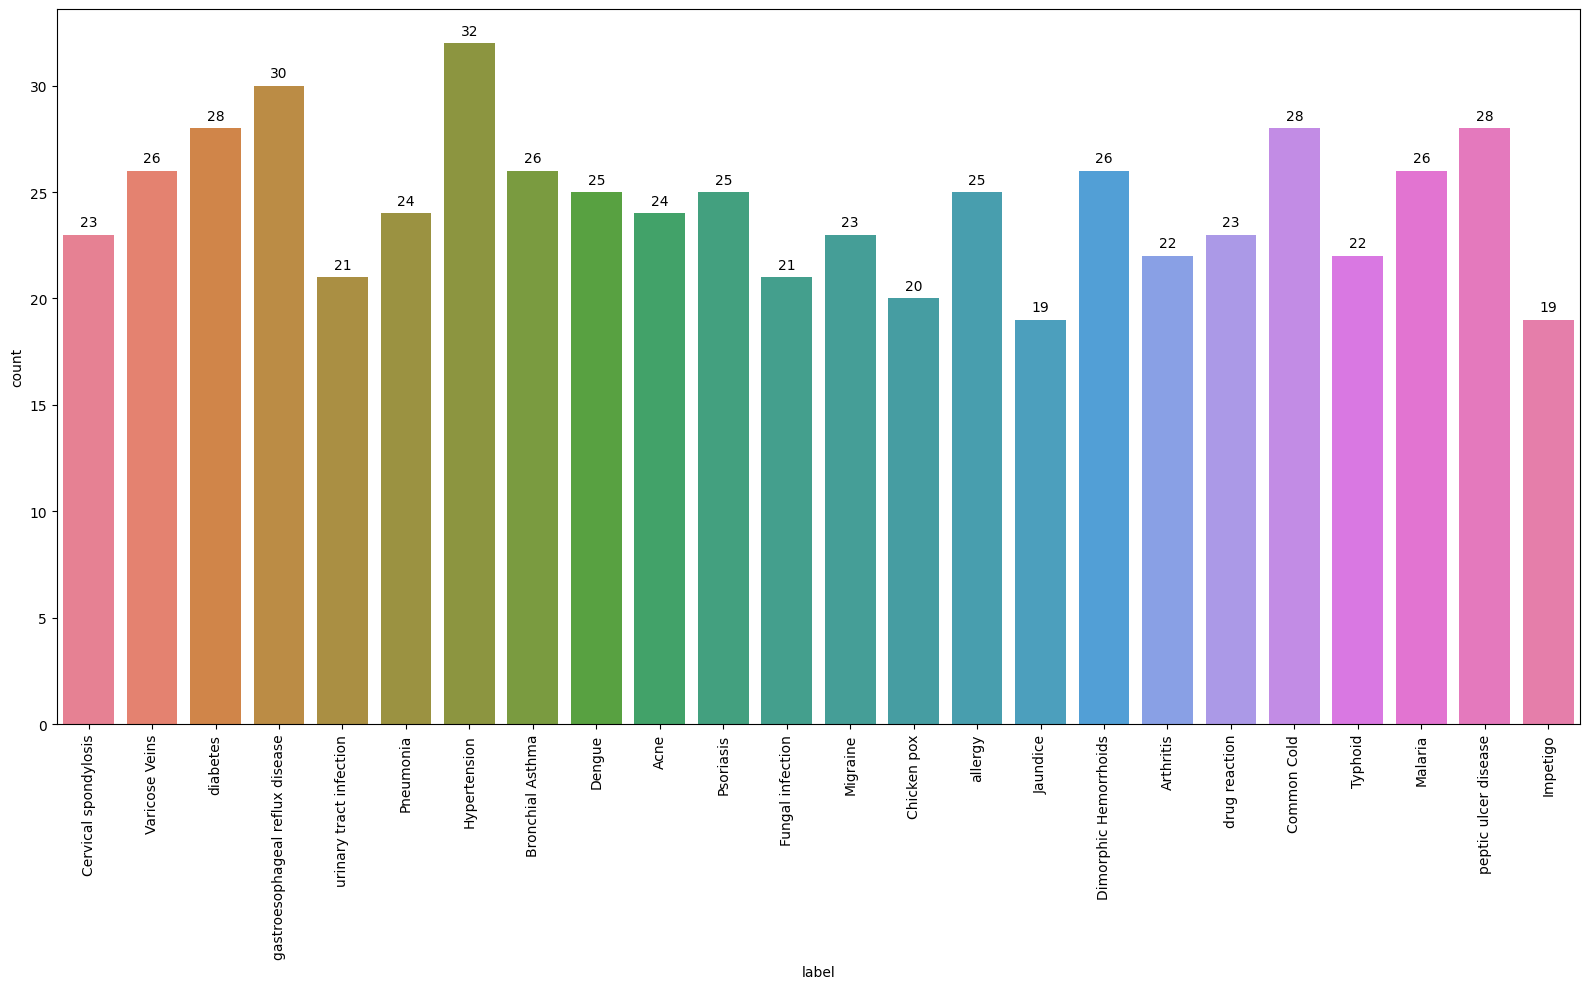

In [10]:
max_len = 150
colors = sns.color_palette('husl', len(df['label'].unique()))
plt.figure(figsize=(16,10))
fig = sns.countplot(x='label',data=df, palette=colors)
plt.xticks(rotation=90,)
plt.tight_layout()
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.show(fig)
plt.close('all')
del fig

*I also generated a bar chart that shows the number of each unique disease names in the database. Due to the fact that each disease is assigned a dozen or several dozen different descriptions, those diseases that have more descriptions will have a better chance of being properly classified in the model for the correct disease they represent.*

### Data cleaning

In [11]:
def clean_text(df,col):
    df[col] = df[col].apply(func=clean_html)
    df[col] = df[col].apply(func=email_address)
    df[col] = df[col].apply(func=remove_)
    df[col] = df[col].apply(func=remove_digits)
    df[col] = df[col].apply(func=remove_links)
    df[col] = df[col].apply(func=remove_special_characters)
    df[col] = df[col].apply(func=removeStopWords)
    df[col] = df[col].apply(func=non_ascii)
    df[col] = df[col].apply(func=punct)
    df[col] = df[col].apply(func=lower)
    return df

In [12]:
preprocessed_df = clean_text(df,'text')
preprocessed_df.head()

,label,text
0,Cervical spondylosis,back pain persistent cough numbness arms legs ...
1,Varicose Veins,noticed blood vessels legs getting noticeable ...
2,diabetes,frequently feel want urinate frequently strong...
3,Cervical spondylosis,my arms legs weak suffering back pain persiste...
4,gastroesophageal reflux disease,my throat feels though food acid backing up ly...


In [13]:
from collections import  Counter
corpus = []
for x in df['text'].str.split():
    corpus.extend(x)
counter=Counter(corpus)
most=counter.most_common()
print(most[0:10])

[('i', 462), ('ve', 335), ('my', 284), ('also', 199), ('lot', 173), ('really', 172), ('skin', 167), ('pain', 153), ('m', 127), ('feel', 119)]


25 most frequently occurring words in symptom descriptions


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


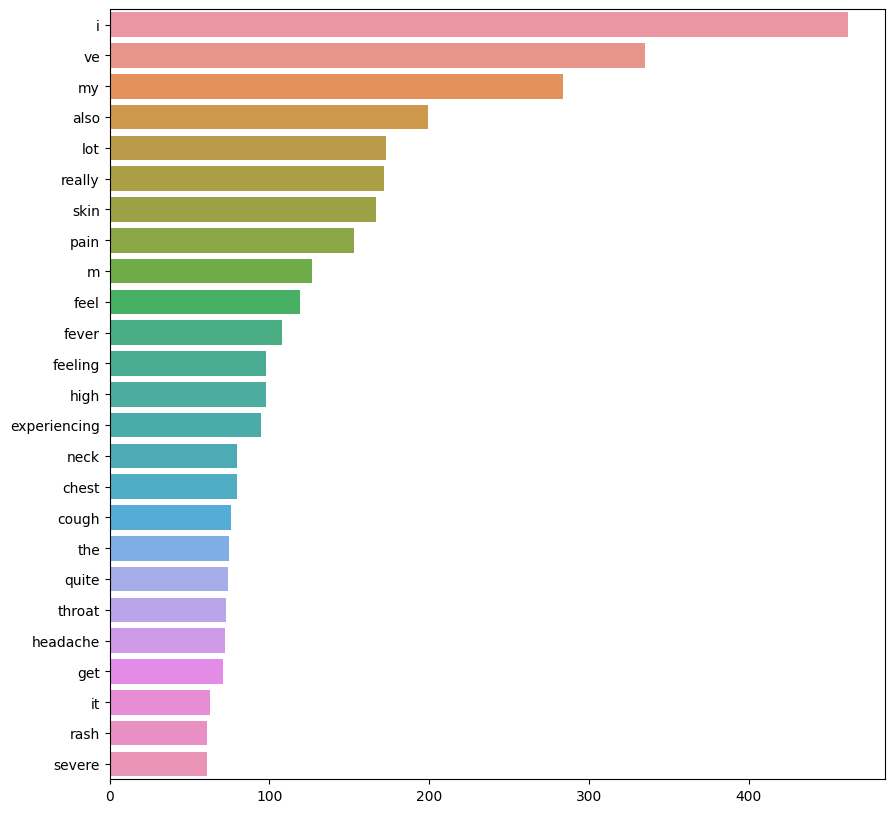

In [14]:
first_n = 25
x, y= [], []
for word,count in most[:first_n]:
        x.append(word)
        y.append(count)
plt.figure(figsize=(10, 10))
sns.barplot(x=y,y=x)
print(f"{first_n} most frequently occurring words in symptom descriptions")

### Stopwords removal and tokenization

In [15]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [16]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Tokenizacja
    words = word_tokenize(text.lower())
    # Removing stopwords and non-alphabetic characters
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

preprocessed_symptoms = preprocessed_df['text'].apply(preprocess_text)
preprocessed_symptoms.head()

0    back pain persistent cough numbness arms legs ...
1    noticed blood vessels legs getting noticeable ...
2    frequently feel want urinate frequently strong...
3    arms legs weak suffering back pain persistent ...
4    throat feels though food acid backing lying ma...
Name: text, dtype: object

*During the processing phase, I cleared the data, removed stopwords and tokenized it. Data cleaning consisted of removing duplicates, unnecessary spaces, capital letters, special characters and punctuation from the "text" column. Then I removed stopwords, i.e. words commonly used, which have no significant meaning and are often excluded from the analysis. Examples of such words are "and", "the", "is", etc. Removing stopwords from text data reduces the so-called 'noise' and improves text mining performance. 
Then I tokenized it, i.e. divided the text into units, such as words and phrases, thanks to which the model can easily identify key symptoms and assign them to the appropriate disease.*

### Model building

TF-IDF:

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
tfidf_features = tfidf_vectorizer.fit_transform(preprocessed_symptoms).toarray()

X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df['label'] , test_size=0.2, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
predictions = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))

Accuracy: 0.85
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       1.00      1.00      1.00         4
               Bronchial Asthma       0.75      1.00      0.86         6
           Cervical spondylosis       0.75      1.00      0.86         3
                    Chicken pox       0.67      0.57      0.62         7
                    Common Cold       0.55      1.00      0.71         6
                         Dengue       1.00      0.60      0.75         5
          Dimorphic Hemorrhoids       1.00      1.00      1.00         4
               Fungal infection       1.00      1.00      1.00         5
                   Hypertension       0.80      1.00      0.89         4
                       Impetigo       1.00      1.00      1.00         3
                       Jaundice       0.67      1.00      0.80         4
                        Malaria    

*To build the model, I used feature extraction TF-IDF and the k-nearest neighbors algorithm.
Based on the pre-processed symptoms, I generated TF-IDF (Term Frequency-Inverse Document Frequency) vectors. This step converts text data into numeric functions appropriate for the model.
The dataset was then split into training and testing sets, with 80% of the data used to train the model and 20% to test its performance.
The K-Nearest Neighbors (KNN) classifier is trained using TF-IDF features and corresponding disease names from the training set.
The results for this model, visible above, can be interpreted as follows: 
The overall accuracy of the model is 85%. This means that the model correctly classified 85% of the instances in the dataset.
Precision, recall, F1 score, support: these metrics provide insight into the model's performance for each disease.
Precision: Indicates how many instances predicted to belong to a given disease actually belong to it. For example, for chicken pox, the accuracy is 67%, which means that of all cases predicted as arthritis, 67% were actually cases of arthritis.
Recall (sensitivity): Measures the number of actual disease instances that the model correctly predicted.
F1 Score: This is an average that gives a score that represents a balance between precision and sensitivity.
Support: This is the number of actual occurrences of the disease in the dataset.*

*Overall, the model performs quite well with an accuracy of 85%. However, there are differences in performance across diseases, with some diseases having high precision, sensitivity and F1 scores, while others have lower scores. For example, diseases such as fungal infection, malaria, and hypertension receive excellent or near-perfect scores, while diseases such as typhoid have very low scores, probably due to difficulty in classification.*

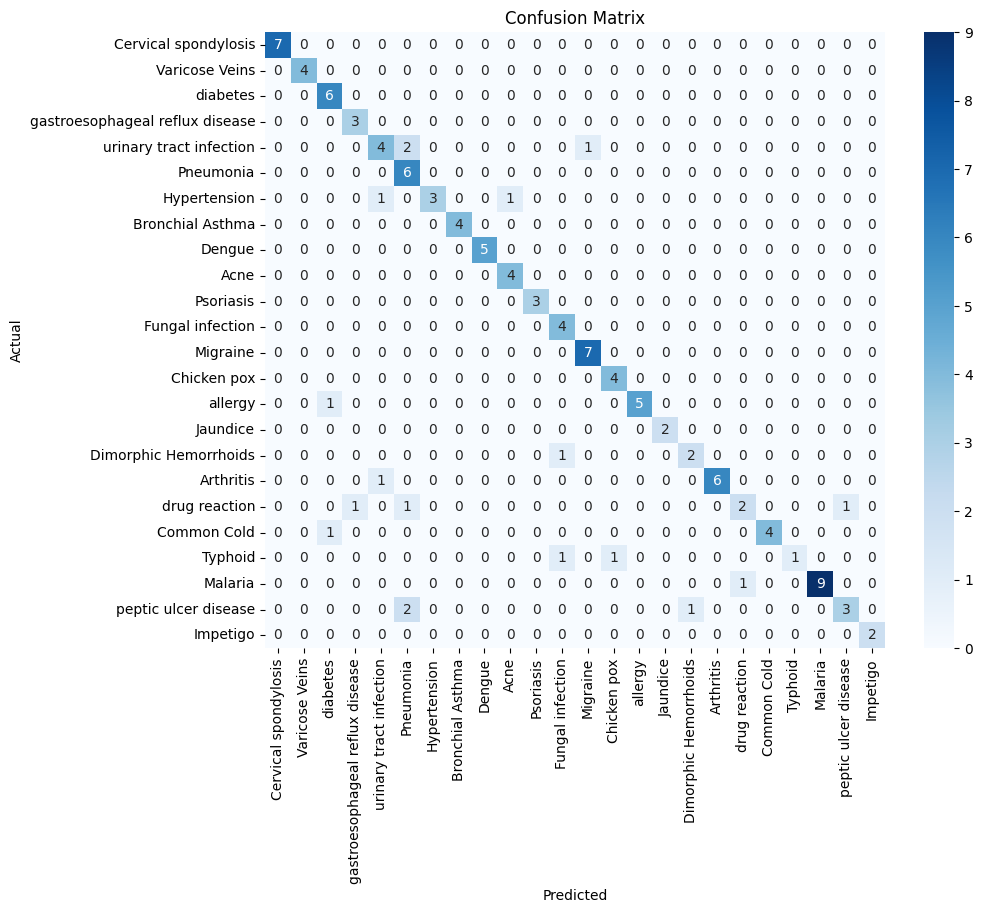

In [19]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

*Confusion Matrix is ​​an N×N matrix, where the rows correspond to the correct decision classes and the columns correspond to the decisions predicted by the classifier.*

### Result

In [20]:
symptom = "Swelling in legs, inflamed calves"
preprocessed_symptom = preprocess_text(symptom)
symptom_tfidf = tfidf_vectorizer.transform([preprocessed_symptom])
predicted_disease = knn_classifier.predict(symptom_tfidf)
print(f'Predicted Disease: {predicted_disease[0]}')

Predicted Disease: Varicose Veins


In [21]:
symptom = "Swollen lymph nodes, red spots"
preprocessed_symptom = preprocess_text(symptom)
symptom_tfidf = tfidf_vectorizer.transform([preprocessed_symptom])
predicted_disease = knn_classifier.predict(symptom_tfidf)
print(f'Predicted Disease: {predicted_disease[0]}')

Predicted Disease: Common Cold


*After testing the model, you can see that it works. Based on symptoms such as swelling of the legs and inflammation in the calves, the model diagnosed the disease as varicose veins, and the swollen lymph nodes and red spots as chickenpox. The model is not perfect and I look forward to improve it in the future, but for now it does it's job.*